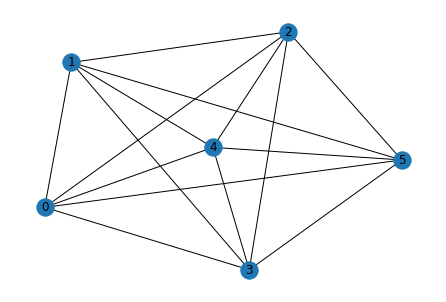

In [1]:
import pennylane as qml
from pennylane import qaoa
from networkx import Graph
import networkx
from pennylane import numpy as np



nodes = 6
wires = nodes
dev = qml.device('default.qubit', wires=wires)
connectivity = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), 
                (1, 2), (1, 3), (1, 4), (1, 5),
                (2, 3), (2, 4), (2, 5), 
                (3, 4), (3, 5), 
                (4, 5)]
graph = Graph(connectivity)
costH, mixerH = qaoa.maxcut(graph)
networkx.draw(graph, with_labels=True)


def QAOALayer(gamma, beta):
    r""" Prepares the QAOA single layer circuit using two parameters :math: '\gamma \text{ and } \beta'

    Args:
        gamma (float): :math: '\gamma'
        beta (float): :math: '\beta'
    """
    qaoa.cost_layer(gamma, costH)
    qaoa.mixer_layer(beta, mixerH)


def circuit(params, wires, **kwargs):
    r""" Create a layered QAOA circuit using Rx Mixing and a ZZ cost function depending on the input graph

    Args:
        params (array): Array of Parameters with len 2*layers. Formatted as [gammas, betas]
        wires (int): number of wires
        **kwargs: {layers: int}
    """
    layers = kwargs['layers']

    for w in wires:
        qml.Hadamard(w)
    qml.layer(QAOALayer, layers, params[:layers], params[layers:])



@qml.qnode(dev)
def getResults(params, wires, **kwargs):
    r""" Create a layered QAOA QNode using Rx mixing and a ZZ cost function depending on the input graph

    Returns measurement probabilities for each output, required to find the optimal cuts

    Args:
        params (array): Array of Parameters with len 2*layers. Formatted as [gammas, betas]
        wires (int): number of wires
        **kwargs: {layers: int}
    """
    layers = kwargs['layers']

    for w in range(wires):
        qml.Hadamard(wires = w)

    qml.layer(QAOALayer, layers, params[:layers], params[layers:])
    return qml.probs(range(wires))

def MaxCutMinimizer():
    r""" Wrapper function for the QAOA MAXCUT minimizer. Iterates over a number of layers until the maximum layers is reached or the minimization stops.

    Prints the optimal states and associated measurement probabilities

    """
    #Initialize optimization variables and counters
    layers = 1
    oldCost = 1
    bestOutput = None
    maxLayers = 7
    #Intialize the parameters to allow for gradient optimization
    params = np.random.uniform(0, 0.1, size=2*layers)
    params = np.array(params, requires_grad=True)


    for i in range(maxLayers-(layers)):
        #Increase total number of optimization steps with increased parameters
        layers += 1
        steps = layers*40
        #Initialize the optimizer
        opt = qml.AdamOptimizer(0.5)
        #Prepare the QAOA cost function circuit, with simultaneous measurements
        costFunc = qml.ExpvalCost(circuit, costH, dev, optimize=True)
        #Generate new values to add to the old guess for new layer
        newGuessVals = np.random.uniform(0, 0.1, size=2)
        params = np.concatenate((params[:layers-1], [newGuessVals[0]], params[layers-1:], [newGuessVals[1]]), requires_grad=True)

        #Optimize over the number of steps defined above
        for i in range(steps):
            params = opt.step(costFunc, params, **{'layers':layers})
        
        #Return the final cost of the optimizer
        newCost = costFunc(params, **{'layers':layers})
        print('Current Cost: {:.8f}'.format(newCost))
        print('Optimal Parameters: {}'.format(params))

        #Check if the new cost is better (ie, less) than the previous iteration
        #Stop the layer increases when the new cost is worse or we hit the defined maximum
        if newCost < oldCost:
            oldCost = newCost
            output = getResults(params, wires, **{'layers': layers})
            bestOutput = output
            if layers == maxLayers:
                print(oldCost)
                resultMask = bestOutput > max(bestOutput)/2
                for i in range(len(resultMask)):
                    if resultMask[i]:
                        print(str(bin(i))[2:].zfill(nodes), output[i])
            continue
        else:
            #Locates and prints the optimal cuts
            print("Final Optimal Cost: {}".format(oldCost))
            resultMask = bestOutput > max(bestOutput)/2
            print('Final Optimal Cuts:')
            print('Cut:    Weight:')
            print('---------------')
            optimalCuts = []
            for i in range(len(resultMask)):
                if resultMask[i]:
                    optimalCuts.append((str(bin(i))[2:].zfill(nodes), output[i]))
            for item in sorted(optimalCuts, key=lambda tup: tup[1])[::-1]:
                print(item[0], item[1])
            break
            
            

        
            


In [2]:
MaxCutMinimizer()

Current Cost: -8.82965038
Optimal Parameters: [-2.08068223 -2.32211254 -0.16200267 -1.22424605]
Current Cost: -8.94446755
Optimal Parameters: [-2.91567793 -2.28791634 -0.07649767 -2.8479859  -2.19353501 -1.09177343]
Current Cost: -8.97711461
Optimal Parameters: [ 2.50208938  0.40423407  0.45172116 -1.48018391  0.43523533 -2.19544391
 -4.18593064 -1.60697279]
Current Cost: -8.80217679
Optimal Parameters: [-2.87305777 -2.36176089  4.80405022 -1.93725241  2.89912397  0.21919595
 -2.39873159 -5.64552842 -1.64629253  0.02180725]
Final Optimal Cost: -8.97711460559015
Final Optimal Cuts:
Cut:    Weight:
---------------
100011 0.04965199206888131
011100 0.04965199206888131
100110 0.0496519920688813
011001 0.0496519920688813
110100 0.049651992068881295
100101 0.049651992068881295
011010 0.049651992068881295
001011 0.049651992068881295
110001 0.04965199206888129
101100 0.04965199206888129
010011 0.04965199206888129
001110 0.04965199206888129
110010 0.04965199206888128
001101 0.04965199206888128
